In this Notebook, we aim at creating some DataDriven surrogate models for the simpliest 1D Poisson Equation: 

$$
- D \Delta u = 1
$$

with D the diffusion coefficient, considerer as scalar and constant over the whole domain. 

Our goal is to create params to solutions models, i.e a mapping from D to u.  

As we want to do it in a data driven manner, we first need a solver to generate data. To do so, we use an implicit finite difference method. 
$$
-D \frac{u_{i-1} -2u_i + u_{i+1}}{(\Delta x)^2} = 1
$$

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import copy

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
sys.path.insert(1, '../..')

## Data Generation

First we need to generate data, to do so, we use the Solver module that will do everything for us in exchange for a dictionnary of params as input. 

There is some already recorded params in the config_step_1.py file 

In [4]:
from solvers.PoissonSolver import PoissonSolver
from config_step_1 import PARAMS_SOLVER

Poisson equation in a \[0, 1\] domain and 101 points for discretizations

In [5]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = PoissonSolver(params=params_solver)

In [6]:
u = solver.solve

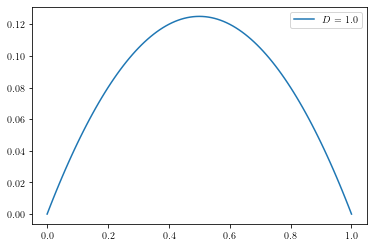

In [7]:
plt.plot(solver.x, u, label=f'$D$ = {solver.D[0]}')
plt.legend()
plt.show()

Now let us generate a dataset using this solver

In [8]:
Dmin, Dmax = 0.1, 10
nD = 1000
D_list = np.linspace(Dmin, Dmax, nD).reshape(-1, 1)
VD = np.ones((nD, solver.nx))*D_list

In [9]:
# Vectorized solver
VU = solver.Vsolve(vect = 'D', D = VD)

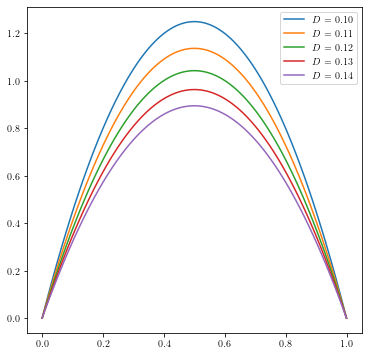

In [10]:
fig, axs = plt.subplots(1, figsize=(6, 6))
for sample in range(0, 5):
    axs.plot(solver.x, VU[sample], label=f'$D$ = {D_list[sample, 0]:.2f}')
plt.legend(loc=1)
plt.show()

## DataDriven surrogate models creation

Now we want to create multiple surrogate models through different methods: POD, MLP, FNO and DeepONet

In practice, we just need to call DDMethod that will handle everything for us

In [11]:
from methods.DataDrivenMethods import DDMethod

In [12]:
# chose methods that you want to use
method_names = ['POD', 'MLP', 'PINN', 'MLPINN', 'DEEPONET', 'FNO']

#method_names = ['MLP']

Best model parameters and optimization hyperparameters for fitting each method have already been computed using optuna (see https://optuna.readthedocs.io/en/stable/index.html), we just need to import them (see optuna folder for more detail on the training)

In [13]:
from config_step_1 import PARAMS_METHODS, HYPERPARAMS_METHODS

In [14]:
PARAMS_METHODS['MLP']

{'method_name': 'MLP',
 'layer_dims': [2, 30, 23, 20, 19, 32, 1],
 'activations': 'tanh',
 'device': device(type='cuda'),
 'seed': 123}

Create DDMethod object for each method

In [15]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

Load models for Neural Networks, and fit for POD

In [16]:
U_sols = VU

In [17]:
d_train, d_val, u_train, u_val = sklearn.model_selection.train_test_split(D_list, U_sols, 
                                                                          test_size=0.2, 
                                                                          random_state=123)

### MLP, PINN

In [18]:
nx = solver.nx
D_train_repeated = torch.Tensor(d_train.repeat(nx, 1)).view(-1, 1)
D_val_repeated = torch.Tensor(d_val.repeat(nx, 1)).view(-1, 1)

In [19]:
x = torch.Tensor(solver.x).view(-1, 1)
X_train = x.repeat(d_train.shape[0], 1)
X_val = x.repeat(d_val.shape[0], 1)

In [20]:
DX_train = torch.cat((D_train_repeated, X_train), dim=1)
DX_val = torch.cat((D_val_repeated, X_val), dim=1)
U_train = torch.Tensor(u_train).view(-1, 1)
U_val = torch.Tensor(u_val).view(-1, 1)

### FNO Data

In [21]:
D_fno_train = torch.Tensor(d_train.repeat(nx, 1)).unsqueeze(-1)
D_fno_val = torch.Tensor(d_val.repeat(nx, 1)).unsqueeze(-1)

In [22]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=U_sols)
    elif method in ['MLP']:
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                DX_train=DX_train, DX_val=DX_val,
                                U_train=U_train, U_val=U_val, 
                                data_ratio=1., physics_ratio=0.)
        # all_methods[method].load_state_dict('optuna/step_1/MLP.pt')
        
    elif method == 'PINN':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                DX_train=DX_train, DX_val=DX_val, 
                                U_train=U_train, U_val=U_val, 
                                data_ratio=0., physics_ratio=1., loss='D', w_r=1.)
        # all_methods[method].load_state_dict('optuna/step_1/PINN.pt')
        
    elif method == 'MLPINN':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                DX_train=DX_train, DX_val=DX_val, 
                                U_train=U_train, U_val=U_val,
                                data_ratio=1., physics_ratio=1., loss='D', w_r=1.)
        # all_methods[method].load_state_dict('optuna/step_1/MLPINN.pt')
        
    elif method == 'DEEPONET':
        all_methods[method].fit(hyperparameters=hyperparams_method, U_train=u_train, U_val=u_val, D_train=d_train, D_val=d_val)
        # all_methods[method].load_state_dict('optuna/step_1/DEEPONET.pt')
        
    elif method == 'FNO':
        all_methods[method].fit(hyperparameters=hyperparams_method, D_train=D_fno_train, D_val=D_fno_val, U_train=u_train, U_val=u_val)
        # all_methods[method].load_state_dict('optuna/step_1/FNO.pt')

Fitting POD
POD fitted
Fitting MLP


[tr : 3.3e-06, val : 5.1e-06]: 100%|█████| 20000/20000 [01:45<00:00, 189.77it/s]


MLP fitted
Fitting PINN


[tr : 6.6e-06, val : 1.4e-06]: 100%|██████| 20000/20000 [05:24<00:00, 61.54it/s]


PINN fitted
Fitting MLPINN


[tr : 7.7e-06, val : 1.1e-06]: 100%|██████| 20000/20000 [06:03<00:00, 55.03it/s]


MLPINN fitted
Fitting DEEPONET


[tr : 3.6e-06, val : 3.3e-06]: 100%|█████| 20000/20000 [00:40<00:00, 492.77it/s]


DEEPONET fitted
Fitting FNO


[tr : 3.9e-09, val : 3.0e-09]: 100%|██████| 20000/20000 [07:27<00:00, 44.69it/s]

FNO fitted


MLP 2355
DEEPONET 2084
PINN 1606
MLPINN 1606
FNO 79117


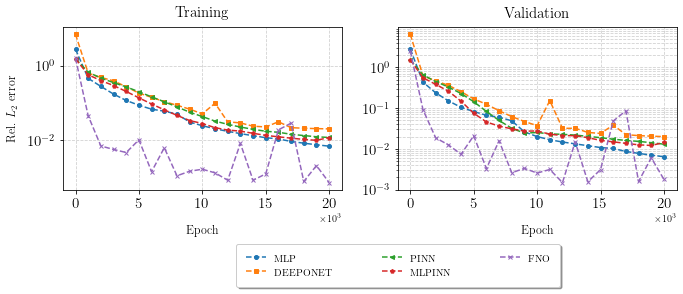

In [28]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3))

for mark, method in zip(['--o', '--s', '--<', '--p', '--x'], ['MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO']):
    
    l2_err_train = all_methods[method]._method._l2_losses['train']
    l2_err_val = all_methods[method]._method._l2_losses['val']
    
    num_parameters = all_methods[method]._method.num_parameters()
    print(method, num_parameters)
    
    axs[0].plot(range(0, 20000, 999), l2_err_train[::999], mark, markersize=4, label = method)
    axs[1].plot(range(0, 20000, 999), l2_err_val[::999], mark, markersize=4, label = method)

axs[0].set_ylabel('Rel. $L_2$ error', size=12, labelpad = 10)
axs[0].set_title('Training', size = 15, pad = 10)
axs[1].set_title('Validation', size = 15, pad = 10)

for i in range(2):
    
    axs[i].grid(True, which='both', alpha = .6, ls='dashed')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Epoch', fontsize = 12, labelpad=15)
    
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    # axs[i].set_xlim(-500, 10500)
    axs[i].ticklabel_format(style='sci', axis='x', scilimits=(3, 3))

axs[0].legend(bbox_to_anchor=(1.8, -0.3), ncol=3, columnspacing = 5, shadow = True, borderpad = 1)
plt.savefig('l2_step_1.pdf', bbox_inches = 'tight')
plt.show()

# Plot performances for each method

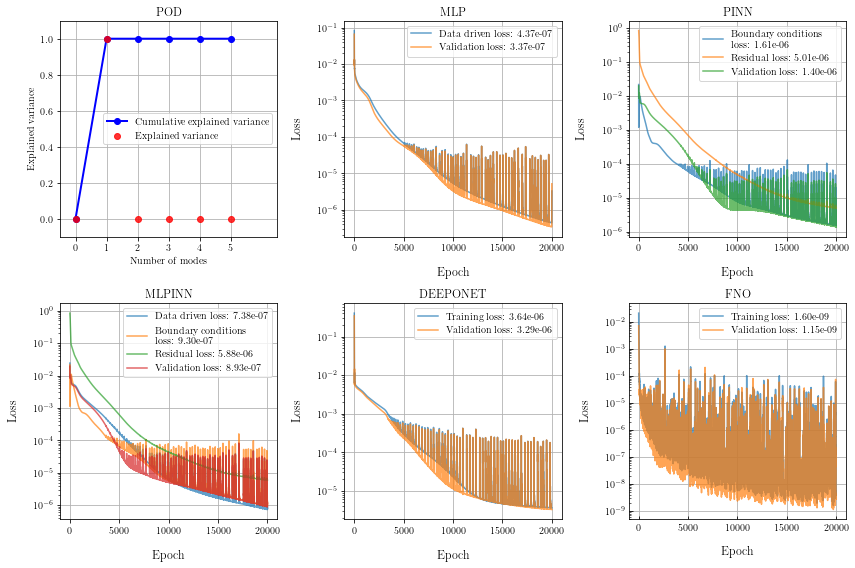

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) 

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].plot(ax)
    ax.title.set_text(method)
    
fig.tight_layout()
plt.show()

## In distribution analysis

In [ ]:
ID_D = 3.

solver.change_D(D=ID_D)
U_FD = solver.solve

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize= (12, 4))
ax_0.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    if method == 'POD':
        U_pred = all_methods[method].apply_method(phi=ID_D,  D =ID_D).flatten()
    else:
        U_pred = all_methods[method].apply_method(phi=[ID_D], D=[ID_D]).flatten()
    ax_0.plot(solver.x, U_pred, label=f'{method}: {np.linalg.norm(U_pred - U_FD, 2):.2e}')
ax_0.title.set_text(f'$D$ = {ID_D}')
ax_0.legend()

OOD_D = 15.
solver.change_D(D=OOD_D)
U_FD = solver.solve


ax_1.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    if method == 'POD':
        U_pred = all_methods[method].apply_method(phi=OOD_D,  D = OOD_D).flatten()
    else:
        U_pred = all_methods[method].apply_method(phi=[OOD_D], D=[OOD_D]).flatten()
    ax_1.plot(solver.x, U_pred, label=f'{method}: {np.linalg.norm(U_pred - U_FD, 2):.2e}')

ax_1.title.set_text(f'$D$ = {OOD_D}')
ax_1.legend()
plt.show()

## Parity plot